In [2]:
import pickle as pkl
import numpy as np

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram
from src.training.training import load_model

In [3]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

base_model = load_model(folder + 'trunc_normal/tn_crps_.pkl')
print(base_model)

Using given parameters for Truncated Normal distribution
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 200)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.3965224]
  b_tn: [ 0.9656694  -0.01666058 -0.146118    0.03517735  0.00451683]
  c_tn: [1.5007248]
  d_tn: [1.0637333]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582



In [7]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test, variances_test = get_tensors(base_model.neighbourhood_size, base_model.feature_names, test_fold, ignore)
X_test = (X_test - base_model.feature_mean) / base_model.feature_std

print(X_test.shape)

(7780, 5)


In [24]:
gev_folder = folder + 'gev/'

gev = load_model(gev_folder + 'gev_crps_.pkl')

gev_100 = load_model(gev_folder + 'gev_crps__epochs100.pkl')

t15 = load_model(gev_folder + 'gev_twcrps_threshold15.0.pkl')
t12 = load_model(gev_folder + 'gev_twcrps_threshold12.0.pkl')

mean12_std4 = load_model(gev_folder + 'gev_twcrps_mean12.0_std4.0.pkl')
mean12_std1 = load_model(gev_folder + 'gev_twcrps_mean12.0_std1.0.pkl')
mean16_std5 = load_model(gev_folder + 'gev_twcrps_mean16.0_std5.0.pkl')


gev_models = {'gev': gev, 'gev_100': gev_100}
t_models = {'t15': t15, 't12': t12}
cdf_models = {'mean12_std4': mean12_std4, 'mean12_std1': mean12_std1, 'mean16_std5': mean16_std5}

gev_models.pop('gev_100')

all_models = {**gev_models, **t_models, **cdf_models}

Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution


In [16]:
samples = 2000

print('Base model CRPS: ', base_model.loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())
for model in gev_models:
    print(model, 'CRPS: ', gev_models[model].loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())

for model in t_models:
    print(model, 'CRPS: ', t_models[model].loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())

for model in cdf_models:
    print(model, 'CRPS: ', cdf_models[model].loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())

Base model CRPS:  0.8910215
gev CRPS:  0.895203
t15 CRPS:  1.2975664
t12 CRPS:  1.231962
mean12_std4 CRPS:  0.90094435
mean12_std1 CRPS:  1.1469588
mean16_std5 CRPS:  0.90595776


There are 104 values in the PIT diagram


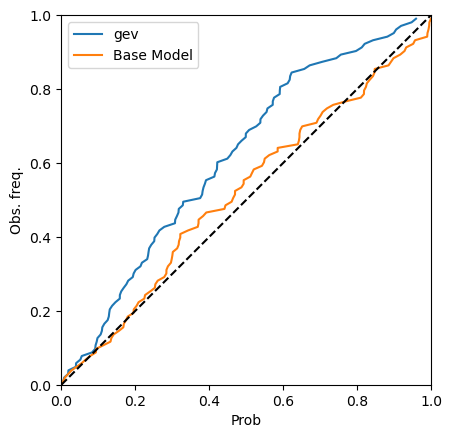

There are 104 values in the PIT diagram


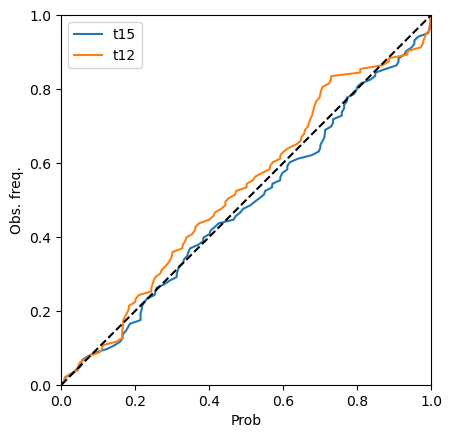

There are 104 values in the PIT diagram


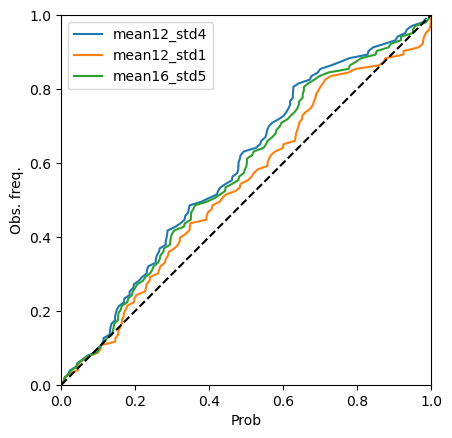

In [17]:
t = 15
make_cpit_diagram_emos(gev_models, X_test, y_test, variances_test, t=t, base_model=base_model)
make_cpit_diagram_emos(t_models, X_test, y_test, variances_test, t=t)
make_cpit_diagram_emos(cdf_models, X_test, y_test, variances_test, t=t)

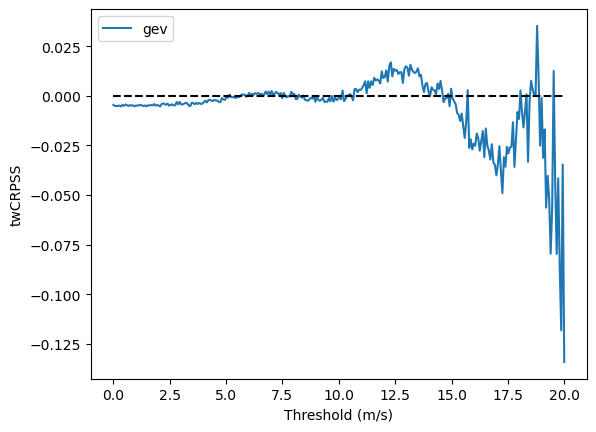

In [19]:
x_values = np.linspace(0, 20, 300)
make_twcrpss_plot(base_model, gev_models, X_test, y_test, variances_test, x_values, sample_size=2500)




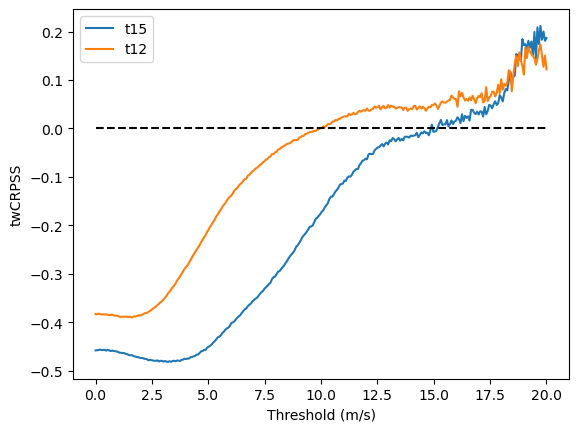

In [21]:
make_twcrpss_plot(base_model, t_models, X_test, y_test, variances_test, x_values, sample_size=2000)

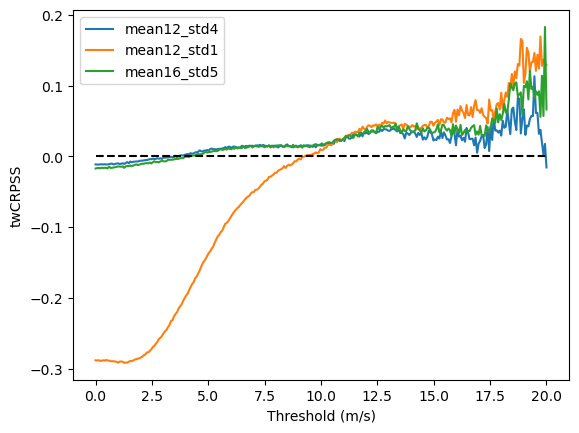

In [22]:
make_twcrpss_plot(base_model, cdf_models, X_test, y_test, variances_test, x_values, sample_size=2000)

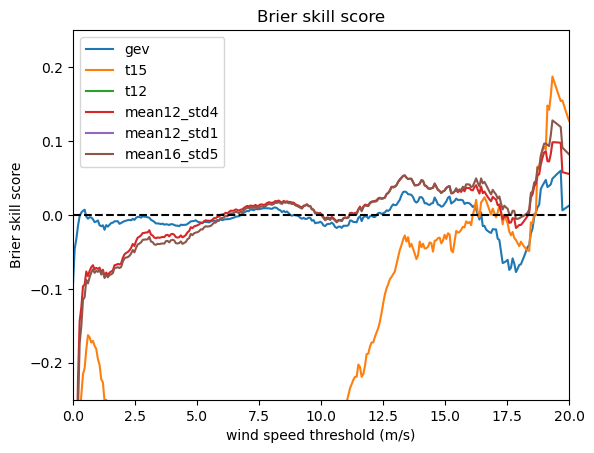

In [28]:
ylim = [-1,1]
#brier_skill_plot(base_model, all_models, X_test, y_test, variances_test, x_values, ylim=ylim)
ylim = [-0.25, 0.25]
brier_skill_plot(base_model, all_models, X_test, y_test, variances_test, x_values, ylim=ylim)

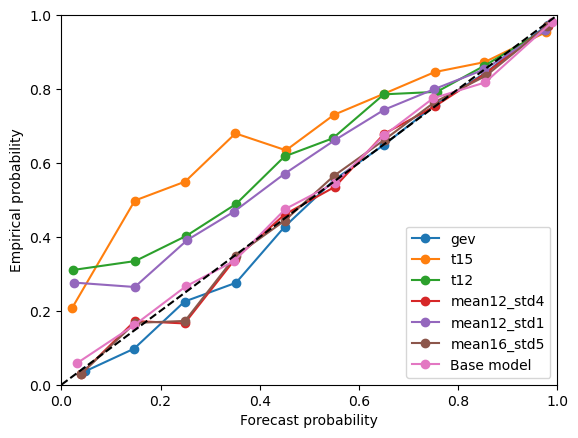

In [29]:
t = 8
make_reliability_diagram(all_models, X_test, y_test, variances_test, t=t, base_model=base_model)